In [367]:
#importando sparksession
%matplotlib inline
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.types import IntegerType,BooleanType,DateType,FloatType
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import numpy as np

In [368]:
#criando um objeto sparksession object e um appName 
sparkSession=SparkSession.builder.appName("c6").getOrCreate()

#lendo documento como pyspark df
df = sparkSession.read.option("header", "true").csv("dados.csv",sep=";")

# Tratando o dataset

In [386]:
dados = (df.withColumnRenamed("Maquina_energialimpa","maqMODELO")
         .withColumnRenamed("Cliente_C6BANK","cliente")
         .withColumnRenamed("fx_prazo","prazoFX")
         .withColumnRenamed("Cliente_PRIME","clientePRIME")
         .withColumnRenamed("Nivel de Risco","clienteRISCO")
         .withColumnRenamed("AnoMês_financiamento","dataFX")
         .withColumnRenamed("Meses desde a Contratação","mesesFX")
         .withColumnRenamed("Valor Financiado (R$)","valorFX")
         .withColumnRenamed("Valor atual (R$)","valorATUAL")
         .withColumnRenamed("Receita mês (R$)","receitaBANCOmes")
         .withColumnRenamed("Comissão Mês (R$)","comissaoBANCOmes")
         .withColumnRenamed("Perda por Inadimplência (R$)","perdaBANCOinad")
         .withColumnRenamed("LUCRO","lucro"))

dados = (dados.withColumn("receitaBANCOmes",regexp_replace('receitaBANCOmes', ',', '.'))
         .withColumn("comissaoBANCOmes",regexp_replace('comissaoBANCOmes', ',', '.'))
         .withColumn("perdaBANCOinad",regexp_replace('perdaBANCOinad', ',', '.'))
         .withColumn("lucro",regexp_replace('lucro', ',', '.')))

dados = dados.filter(dados.dataFX != '2070-12-01')

dados = (dados.withColumn("cliente",dados.cliente.cast(IntegerType()))
         .withColumn("clientePRIME",dados.clientePRIME.cast(BooleanType()))
         .withColumn("dataFX",dados.dataFX.cast(DateType()))
         .withColumn("mesesFX",dados.mesesFX.cast(IntegerType()))
         .withColumn("valorFX",dados.valorFX.cast(IntegerType()))
         .withColumn("valorATUAL",dados.valorATUAL.cast(IntegerType()))
         .withColumn("receitaBANCOmes",dados.receitaBANCOmes.cast(FloatType()))
         .withColumn("comissaoBANCOmes",dados.comissaoBANCOmes.cast(FloatType()))
         .withColumn("perdaBANCOinad",dados.perdaBANCOinad.cast(FloatType()))
         .withColumn("lucro",dados.lucro.cast(FloatType())))

dados.printSchema()

root
 |-- maqMODELO: string (nullable = true)
 |-- cliente: integer (nullable = true)
 |-- prazoFX: string (nullable = true)
 |-- clientePRIME: boolean (nullable = true)
 |-- clienteRISCO: string (nullable = true)
 |-- dataFX: date (nullable = true)
 |-- mesesFX: integer (nullable = true)
 |-- valorFX: integer (nullable = true)
 |-- valorATUAL: integer (nullable = true)
 |-- receitaBANCOmes: float (nullable = true)
 |-- comissaoBANCOmes: float (nullable = true)
 |-- perdaBANCOinad: float (nullable = true)
 |-- lucro: float (nullable = true)



In [387]:
dados2 = dados.dropna()

### Transformando o código para saber o número real de clientes. 
df_teste = dados2.select("cliente")
teste= df_teste.toPandas()
df_mesesFX = dados2.select("mesesFX")
mesesFX = df_mesesFX.toPandas()
p = 0

for i,(cliente,meses) in enumerate(zip(teste.cliente, mesesFX.mesesFX)):
    if meses == 0:
        p += 1
    teste.cliente[i] = p
    
# substituindo a coluna clientes
dados2 = dados2.toPandas()
dados2.cliente = teste.cliente
dados2 = spark.createDataFrame(dados2)

dados2.createOrReplaceTempView("tab_dados")

## Criando view que será utilizada por todo a análise (clientes_prime)

clientes_prime = sparkSession.sql("select cliente, clientePRIME, maqMODELO, clienteRISCO, sum(receitaBANCOmes), sum(comissaoBANCOmes), sum(perdaBANCOinad), sum(lucro), prazoFX from tab_dados group by clientePRIME, maqMODELO, cliente, clienteRISCO, prazoFX order by cliente")
clientes_prime = (clientes_prime.withColumnRenamed("sum(receitaBANCOmes)","receitaBANCOmes")
                        .withColumnRenamed("sum(comissaoBANCOmes)","comissaoBANCOmes")
                        .withColumnRenamed("sum(perdaBANCOinad)","perdaBANCOinad")
                        .withColumnRenamed("sum(lucro)","lucro"))

clientes_prime.createOrReplaceTempView("tab_prime")

## criando uma label para o risco (apenas para melhor visualização dos gráficos - será utilizada apenas na análise dos RISCOS)

clientes_prime2 = clientes_prime
risco = clientes_prime2.select('clienteRISCO').toPandas()

score_order_df = np.repeat(1,902)
score_order = pd.DataFrame(score_order_df, columns = ['score_order'])

for i,(r,s) in enumerate(zip(risco.clienteRISCO,score_order.score_order)):
    if r == 'Alto Risco':
        score_order.score_order[i] = 3
    elif r == 'Médio Risco':
        score_order.score_order[i] = 2
        
clientes_prime2 = clientes_prime2.toPandas()
clientes_prime2['risco_label'] = score_order.score_order
clientes_prime2 = spark.createDataFrame(clientes_prime2)

clientes_prime2.createOrReplaceTempView("tab_prime2")

#### Entre as principais correções e adaptações que foram necessárias no dataset original estão:
* Deletar os dados do mês de dezembro de 2070. Os valores pareciam conter erros, provavelmente por ser o ultimo mês de coleta, todos financiamentos constavam com 100% de perda por inadimplência.
* Criar uma função que nos ajudasse a descobrir quantos clientes/financiamentos de fato o banco tinha, pois nos dados originais cada linha representava um dado cliente em um dado mês.

**Obs: Por falta de id dos clientes, foi desconsiderada a hipótese de clientes recorrentes, assumiu-se que cada novo financiamento pertencia a um novo cliente.**  

# Comparando clientes primes e não-primes

In [388]:
sparkSession.sql("select clientePRIME, count(*) as n_cp from tab_prime group by clientePRIME").show()

sparkSession.sql("select clientePRIME, count(*) as maq_energiaeolica from tab_prime where maqMODELO = 'Energia Eólica' group by clientePRIME").show()

sparkSession.sql("select clientePRIME, count(*) as maq_energiasolar from tab_prime where maqMODELO = 'Energia Solar' group by clientePRIME").show()

+------------+----+
|clientePRIME|n_cp|
+------------+----+
|        true| 313|
|       false| 519|
+------------+----+

+------------+-----------------+
|clientePRIME|maq_energiaeolica|
+------------+-----------------+
|        true|              146|
|       false|              240|
+------------+-----------------+

+------------+----------------+
|clientePRIME|maq_energiasolar|
+------------+----------------+
|        true|             167|
|       false|             279|
+------------+----------------+



In [389]:
cp = 313/(313+519)*100
print(f'Os clientes prime representam {cp:.2f}% do total de clientes do banco.')
print(f'{146/313*100:.2f}% dos clientes prime preferem energia Eolica a Solar.')
print(f'{240/519*100:.2f}% dos clientes não-prime preferem energia Eolica a Solar.')

Os clientes prime representam 37.62% do total de clientes do banco.
46.65% dos clientes prime preferem energia Eolica a Solar.
46.24% dos clientes não-prime preferem energia Eolica a Solar.


**Parece haver pouca diferença na preferência dos clientes. Observa-se uma leve preferência pela energia solar para ambas as classificações de clientes (ou talvez sua oferta seja maior, o que será verificado posteriormente).**

## Perfil de Risco

In [390]:
sparkSession.sql("select clienteRISCO, clientePRIME, count(*) as total from tab_prime2 group by clienteRISCO, clientePRIME, risco_label order by risco_label, 2 DESC").show()

+------------+------------+-----+
|clienteRISCO|clientePRIME|total|
+------------+------------+-----+
| Baixo Risco|        true|  107|
| Baixo Risco|       false|  174|
| Médio Risco|        true|  104|
| Médio Risco|       false|  176|
|  Alto Risco|        true|  102|
|  Alto Risco|       false|  169|
+------------+------------+-----+



In [391]:
print(f'\nClientes prime:\n\
{107/313*100:.2f}% são classificados como alto risco\n\
{104/313*100:.2f}% são classificados como médio risco\n\
{102/313*100:.2f}% são classificados como baixo risco')
print(f'\nClientes não-prime:\n\
{174/519*100:.2f}% são classificados como alto risco\n\
{176/519*100:.2f}% são classificados como médio risco\n\
{169/519*100:.2f}% são classificados como baixo risco')


Clientes prime:
34.19% são classificados como alto risco
33.23% são classificados como médio risco
32.59% são classificados como baixo risco

Clientes não-prime:
33.53% são classificados como alto risco
33.91% são classificados como médio risco
32.56% são classificados como baixo risco


**A distribuição quanto à classificação de risco parece ser homogênea, tanto para clientes prime como não prime.**

## Risco x Receita

In [392]:
sparkSession.sql("select clienteRISCO, avg(receitaBANCOmes) as receitaMEDIA from tab_prime2 group by clienteRISCO, risco_label order by risco_label").show()

+------------+------------------+
|clienteRISCO|      receitaMEDIA|
+------------+------------------+
| Baixo Risco|3541.5231249196145|
| Médio Risco| 5821.915713433628|
|  Alto Risco| 5750.932465736111|
+------------+------------------+



In [442]:
print(f'A receita média gerada por clientes de médio risco é {(5821.915713433628/5750.932465736111-1)*100:.2f}% maior que a receita \
média gerada por clientes de alto risco!')

A receita média gerada por clientes de médio risco é 1.23% maior que a receita média gerada por clientes de alto risco!


**Esta parece ser uma política fadada ao fracasso, que fere um dos princípios básicos de investimentos: quanto maior o risco maior o retorno esperado. Para que faça sentido ceder crédito a clientes de alto risco é necessário que a receita acompanhe esse risco.**

In [394]:
sparkSession.sql("select clienteRISCO, avg(lucro) as lucroMEDIO from tab_prime2 group by clienteRISCO, risco_label order by risco_label").show()

+------------+------------------+
|clienteRISCO|        lucroMEDIO|
+------------+------------------+
| Baixo Risco|3193.8231327012713|
| Médio Risco| 4378.027861995064|
|  Alto Risco|3456.1442700677526|
+------------+------------------+



In [443]:
print(f'O lucro médio gerado por clientes de médio risco é {(4378.027861995064/3456.1442700677526-1)*100:.2f}% maior que o lucro \
médio gerado por clientes de alto risco!')

O lucro médio gerado por clientes de médio risco é 26.67% maior que o lucro médio gerado por clientes de alto risco!


**Como era de se esperar, pela análise feita anteriormente, o lucro médio de clientes de médio risco é maior que o lucro médio de clientes de alto risco. Em um período de crise, como é o caso, pode valer a pena não conceder mais financiamentos para clientes de alto risco.** 
  
**Em um momento posterior, deve-se aumentar o retorno sob clientes de alto risco (seja aumentando juros, ou tarifas ou ambos) para que se volte a conceder financiamentos para esse tipo de cliente.**

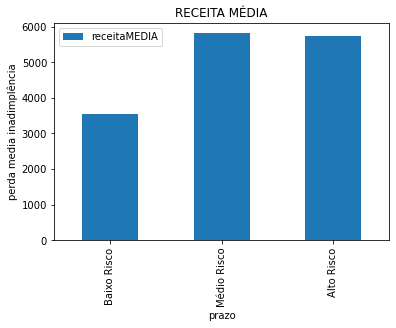

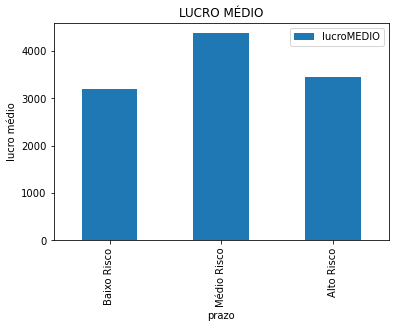

In [396]:
risco_inad_lucro_df = sparkSession.sql("select clienteRISCO, avg(lucro) as lucroMEDIO, avg(receitaBANCOmes) as receitaMEDIA from tab_prime2 group by clienteRISCO, risco_label order by risco_label")
risco_inad_lucro = risco_inad_lucro_df.toPandas()

risco_inad_lucro.plot(kind='bar',x='clienteRISCO',y='receitaMEDIA')
plt.title('RECEITA MÉDIA')
plt.xlabel('prazo')
plt.ylabel('perda media inadimplência')
plt.show()

risco_inad_lucro.plot(kind='bar',x='clienteRISCO',y='lucroMEDIO')
plt.title('LUCRO MÉDIO')
plt.xlabel('prazo')
plt.ylabel('lucro médio')
plt.show()

## Receita

In [397]:
sparkSession.sql("select clientePRIME, sum(receitaBANCOmes) as receitaTOTAL, avg(receitaBANCOmes) as receitaMEDIA from tab_prime group by clientePRIME").show()

+------------+------------------+------------------+
|clientePRIME|      receitaTOTAL|      receitaMEDIA|
+------------+------------------+------------------+
|        true| 744526.0996895954|2378.6776347910395|
|       false|3439280.9963887185| 6626.745657781731|
+------------+------------------+------------------+



In [444]:
print(f'Apesar de representarem {cp:.2f}% da base total de clientes, os clientes prime representam apenas {744526.0996895954/(744526.0996895954+3439280.9963887185)*100:.2f}% da receita total.')
print(f'A receita média por cliente não-prime é {6626.745657781731/2378.6776347910395:.2f}x maior que a dos clientes prime.')

Apesar de representarem 37.62% da base total de clientes, os clientes prime representam apenas 17.80% da receita total.
A receita média por cliente não-prime é 2.79x maior que a dos clientes prime.


## Comissão

In [399]:
sparkSession.sql("select clientePRIME, sum(comissaoBANCOmes) as comissaoTOTAL, avg(comissaoBANCOmes) as comissaoMEDIA from tab_prime group by clientePRIME").show()

+------------+------------------+------------------+
|clientePRIME|     comissaoTOTAL|     comissaoMEDIA|
+------------+------------------+------------------+
|        true|226938.09943706542| 725.0418512366307|
|       false| 872607.7987681404|1681.3252384742589|
+------------+------------------+------------------+



In [445]:
print(f'Apesar de representarem {cp:.2f}% da base total de clientes, os clientes prime representam apenas {226938.09943706542/(226938.09943706542+872607.7987681404)*100:.2f}% da comissão total.')
print(f'A comissão média de clientes não-prime é {1681.3252384742589/725.0418512366307:.2f}x maior que a dos clientes prime.')

Apesar de representarem 37.62% da base total de clientes, os clientes prime representam apenas 20.64% da comissão total.
A comissão média de clientes não-prime é 2.32x maior que a dos clientes prime.


## Perda por inadimplência

In [402]:
sparkSession.sql("select clientePRIME, sum(perdaBANCOinad) as perdaporinadimplenciaTOTAL, avg(perdaBANCOinad) as perdaporinadimplenciaMEDIA from tab_prime group by clientePRIME").show()

+------------+--------------------------+--------------------------+
|clientePRIME|perdaporinadimplenciaTOTAL|perdaporinadimplenciaMEDIA|
+------------+--------------------------+--------------------------+
|        true|         345796.2001766339|        1104.7801922576164|
|       false|        1877581.2011193335|        3617.6901755671165|
+------------+--------------------------+--------------------------+



In [446]:
print(f'Apesar de representarem {cp:.2f}% da base total de clientes, os clientes prime representam apenas {345796.2001766339/(345796.2001766339+1877581.2011193335)*100:.2f}% da perda total \npor inadimplência.')
print(f'A perda por inadimplência média por cliente não-prime é {3617.6901755671165/1104.7801922576164:.2f}x maior que a dos clientes prime.')

Apesar de representarem 37.62% da base total de clientes, os clientes prime representam apenas 15.55% da perda total 
por inadimplência.
A perda por inadimplência média por cliente não-prime é 3.27x maior que a dos clientes prime.


**Percebe-se que a perda por inadimplência é muito maior para clientes não-prime, apesar da classificação de risco ser bem parecida entre primes e não-primes, o que sugere que deveriam ser feitas melhorias no algoritmo classificatório de risco.**

## Lucro

In [404]:
sparkSession.sql("select clientePRIME, sum(lucro) as lucroTOTAL, avg(lucro) as lucroMEDIO from tab_prime where group by clientePRIME").show()

+------------+------------------+------------------+
|clientePRIME|        lucroTOTAL|        lucroMEDIO|
+------------+------------------+------------------+
|        true| 625654.3003022373|1998.8955281221638|
|       false|2434272.8985337988|  4690.31387000732|
+------------+------------------+------------------+



In [406]:
print(f'Apesar de representarem {cp:.2f}% da base total de clientes, os clientes prime representam apenas {625654.3003022373/(625654.3003022373+2434272.8985337988)*100:.2f}% do lucro total.')
print(f'Apesar da perda média por inadimplência ser {3617.6901755671165/1104.7801922576164:.2f}x maior, o lucro médio por cliente não-prime é {4690.31387000732/1998.8955281221638:.2f}x maior.')

Apesar de representarem 37.62% da base total de clientes, os clientes prime representam apenas 20.45% do lucro total.
Apesar da perda média por inadimplência ser 3.27x maior, o lucro médio por cliente não-prime é 2.35x maior.


**Investir recursos nos clientes não-prime parece mais vantajoso. Apesar disso, os clientes prime têm o seu papel como, por exemplo, gerar mais recursos para que o banco continue a fazer mais financiamentos.**

# Comparando os financiamentos entre os modelos das máquinas

In [447]:
sparkSession.sql("select maqMODELO, count(*) as n_financiamentos from tab_prime group by maqMODELO order by 1 asc").show()

+--------------+----------------+
|     maqMODELO|n_financiamentos|
+--------------+----------------+
|Energia Eólica|             386|
| Energia Solar|             446|
+--------------+----------------+



In [411]:
print(f'A oferta de financiamento para maquinas de Energia solar representa {446/(446+386)*100:.0f}% do total de financiamentos.')

A oferta de financiamento para maquinas de Energia solar representa 54% do total de financiamentos.


In [412]:
sparkSession.sql("select maqMODELO, sum(receitaBANCOmes) as receitaTOTAL, avg(receitaBANCOmes) as receitaMEDIA from tab_prime group by maqMODELO").show()

+--------------+------------------+------------------+
|     maqMODELO|      receitaTOTAL|      receitaMEDIA|
+--------------+------------------+------------------+
|Energia Eólica| 802360.6988380402|2078.6546602021767|
| Energia Solar|3381446.3972402737| 7581.718379462497|
+--------------+------------------+------------------+



In [415]:
receitas_maq = [3381446.3972402737/(3381446.3972402737+802360.6988380402)*100,7581.718379462497/2078.6546602021767]
print(f'Apesar de representar {446/(446+386)*100:.0f}% do total de financiamentos, o financiamento das máquinas de energia \
solar é responsável\npor {receitas_maq[0]:.2f}% do total da receita e tem receita média {receitas_maq[1]:.2f}x \
superior ao financiamento das máquinas de energia Eólica.')

Apesar de representar 54% do total de financiamentos, o financiamento das máquinas de energia solar é responsável
por 80.82% do total da receita e tem receita média 3.65x superior ao financiamento das máquinas de energia Eólica.


**Investir mais nesse mercado parece uma boa ideia.**

# Analisando o prazo de financiamento

In [416]:
sparkSession.sql("select prazoFX, count(*) as prime_n from tab_prime group by prazoFX order by 1").show()

+----------+-------+
|   prazoFX|prime_n|
+----------+-------+
|  a) 0 - 6|    144|
| b) 7 - 12|    144|
|c) 13 - 24|    144|
|d) 25 - 36|    144|
|e) 36 - 48|    127|
|   f) > 48|    115|
|g) Missing|     14|
+----------+-------+



A classe **g** representa os financimentos cujo prazo não conhecemos, portanto será excluída dessa análise.

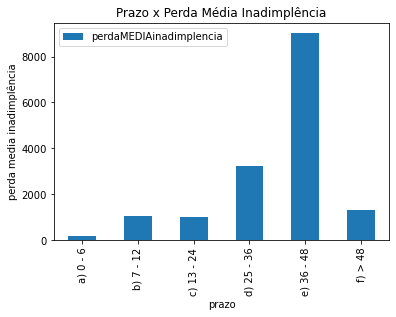

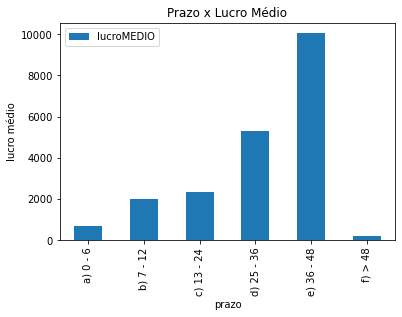

In [417]:
prazo_inad_lucro_df = sparkSession.sql("select prazoFX, avg(perdaBANCOinad) as perdaMEDIAinadimplencia, avg(lucro) as lucroMEDIO from tab_fx_p group by prazoFX order by 1")
prazo_inad_lucro = prazo_inad_lucro_df.toPandas()

prazo_inad_lucro.plot(kind='bar',x='prazoFX',y='perdaMEDIAinadimplencia')
plt.title('Prazo x Perda Média Inadimplência')
plt.xlabel('prazo')
plt.ylabel('perda media inadimplência')
plt.show()

prazo_inad_lucro.plot(kind='bar',x='prazoFX',y='lucroMEDIO')
plt.title('Prazo x Lucro Médio')
plt.xlabel('prazo')
plt.ylabel('lucro médio')
plt.show()

Considerando os prazos até 48 meses, é possível observar correlação positiva entre prazo e lucro e entre prazo e perda por inadimplência. Vamos observar os números mais a fundo.

+----------+-----------------------+------------------+
|   prazoFX|perdaMEDIAinadimplencia|        lucroMEDIO|
+----------+-----------------------+------------------+
|  a) 0 - 6|     196.44930611431806| 763.0555561821287|
| b) 7 - 12|      1103.247914693008| 2187.483331112191|
|c) 13 - 24|     1042.9354158208396|2553.6875011601173|
|d) 25 - 36|     3421.5423577485294| 5813.768753970921|
|e) 36 - 48|      9697.862220450708|11051.981086002854|
|   f) > 48|      1405.503479191661|231.31391657221576|
+----------+-----------------------+------------------+

Razões (lucro médio)/(perda média por inadimplência)

A: 3.88, B: 1.98, C: 2.45, D: 1.70, E: 1.14, F: 0.16


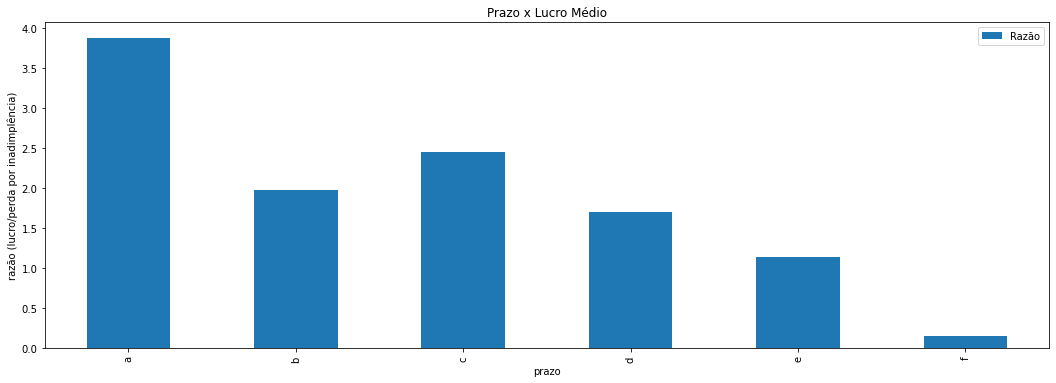

In [448]:
clientes_prime2 = clientes_prime.filter(col("prazoFX").rlike("[^g) Missing]"))
clientes_prime2.createOrReplaceTempView("tab_fx_p")

sparkSession.sql("select prazoFX, avg(perdaBANCOinad) as perdaMEDIAinadimplencia, avg(lucro) as lucroMEDIO from tab_fx_p group by prazoFX order by 1").show()

print('Razões (lucro médio)/(perda média por inadimplência)')
print(f'\nA: {763.0555561821287/196.44930611431806:.2f}, B: {2187.483331112191/1103.247914693008:.2f}, \
C: {2553.6875011601173/1042.9354158208396:.2f}, D: {5813.768753970921/3421.5423577485294:.2f}, \
E: {11051.981086002854/9697.862220450708:.2f}, F: {231.31391657221576/1405.503479191661:.2f}')

razao_lucro_perda = [['a',3.88],['b',1.98],['c',2.45],['d',1.70],['e',1.14],['f',0.16]]
colunas = ['Prazo','Razão']
graph_razao = pd.DataFrame(razao_lucro_perda, columns = colunas)

graph_razao.plot(kind='bar',x='Prazo',y='Razão')
plt.title('Prazo x Lucro Médio')
plt.xlabel('prazo')
plt.ylabel('razão (lucro/perda por inadimplência)')
plt.show()

**No comparativo chegamos a conclusão que os melhores prazos para se concender financimento são 0-6 meses(a) e 13-24 meses(c), respectivamente. Percebemos que apesar do maior risco (medido aqui pela inadimplência média), quanto maior o prazo do financiamento maior será o lucro médio (excessão para o prazos superiores a 48 meses(f)). Mas em um cenário ecônomico conturbado, creio que o melhor seja focar nos prazos com razões vencedoras.**

## Analisando se o C6 perdeu clientes (financiamentos/mês) com a pandemia

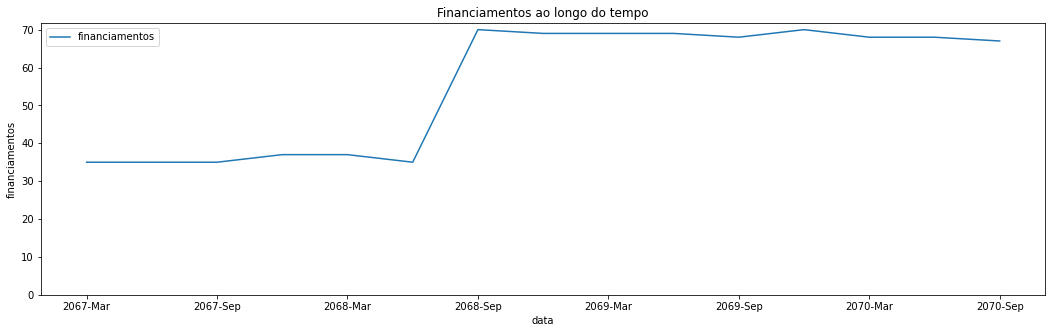

In [449]:
data_clientes_df = sparkSession.sql("select date_format(dataFX, 'y-MMM') as data, count(dataFX) as financiamentos from (select cliente, dataFX, count(dataFX) from tab_dados group by cliente, dataFX) group by dataFX order by dataFX")
#sparkSession.sql("select dataFX, count(dataFX) from (select cliente, dataFX, count(dataFX) from tab_dados group by cliente, dataFX) group by dataFX order by 1").show()
data_clientes = data_clientes_df.toPandas()

plt.rcParams["figure.figsize"] = (18,5)
data_clientes.plot(x='data',y='financiamentos')
plt.title('Financiamentos ao longo do tempo')
plt.xlabel('data')
plt.ylabel('financiamentos')
plt.ylim(ymin=0)
plt.show()

**Os negócios parecem estar indo muito bem.**

## Analisando o lucro e perda por inadimplência

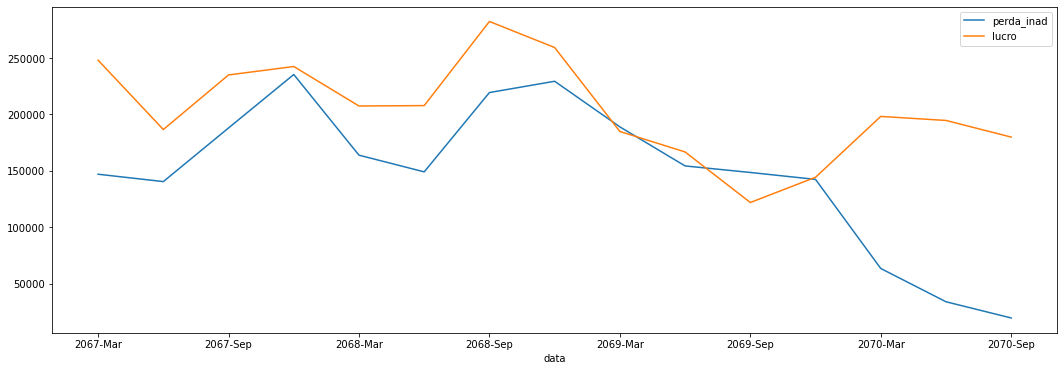

In [429]:
#sparkSession.sql("select dataFX, count(dataFX) from (select cliente, dataFX, count(dataFX) from tab_dados group by cliente, dataFX) group by dataFX order by 1").show()
data_lucro_df = sparkSession.sql("select date_format(dataFX, 'y-MMM') as data, sum(lucro) as lucro from tab_dados group by dataFX order by dataFX")
data_inad_df = sparkSession.sql("select date_format(dataFX, 'y-MMM') as data, sum(perdaBANCOinad) as perda_inad from tab_dados group by dataFX order by dataFX")
data_lucro = data_lucro_df.toPandas()
data_inad = data_inad_df.toPandas()

g1 = data_inad.plot(x='data',y='perda_inad')
data_lucro.plot(x='data',y='lucro', ax=g1)
plt.show()

# CENÁRIO ECONÔMICO

In [434]:
ce = sparkSession.read.option("header", "true").csv("cen_eco.csv",sep=";")

ce = (ce.withColumn('txDESEMPREGO', regexp_replace('txDESEMPREGO', '%', ''))
      .withColumn('txDESEMPREGO', regexp_replace('txDESEMPREGO', ',', '.'))
      .withColumn('famENDIVIDADAS', regexp_replace('famENDIVIDADAS', '%', ''))
      .withColumn('famENDIVIDADAS', regexp_replace('famENDIVIDADAS', ',', '.'))
      .withColumn('famCONTAatrasada', regexp_replace('famCONTAatrasada', '%', ''))
      .withColumn('famCONTAatrasada', regexp_replace('famCONTAatrasada', ',', '.'))
      .withColumn('famINADIMPLENTE', regexp_replace('famINADIMPLENTE', '%', ''))
      .withColumn('famINADIMPLENTE', regexp_replace('famINADIMPLENTE', ',', '.'))
      .withColumn('igpm', regexp_replace('igpm', '%', ''))
      .withColumn('igpm', regexp_replace('igpm', ',', '.'))
      .withColumn('ipca', regexp_replace('ipca', '%', ''))
      .withColumn('ipca', regexp_replace('ipca', ',', '.'))
      .withColumn('IC_consumidor', regexp_replace('IC_consumidor', ',', '.'))
      .withColumn('IC_industria', regexp_replace('IC_industria', ',', '.'))
      .withColumn('IC_industria', regexp_replace('IC_industria', ',', '.'))
      .withColumn('IC_servicos', regexp_replace('IC_servicos', ',', '.'))
      .withColumn('IC_comercio', regexp_replace('IC_comercio', ',', '.'))
      .withColumn('IC_construcao', regexp_replace('IC_construcao', ',', '.')))

ce = sparkSession.read.option("header", "true").csv("cen_eco.csv",sep=";")

ce = (ce.withColumn('txDESEMPREGO', regexp_replace('txDESEMPREGO', '%', ''))
      .withColumn('txDESEMPREGO', regexp_replace('txDESEMPREGO', ',', '.'))
      .withColumn('famENDIVIDADAS', regexp_replace('famENDIVIDADAS', '%', ''))
      .withColumn('famENDIVIDADAS', regexp_replace('famENDIVIDADAS', ',', '.'))
      .withColumn('famCONTAatrasada', regexp_replace('famCONTAatrasada', '%', ''))
      .withColumn('famCONTAatrasada', regexp_replace('famCONTAatrasada', ',', '.'))
      .withColumn('famINADIMPLENTE', regexp_replace('famINADIMPLENTE', '%', ''))
      .withColumn('famINADIMPLENTE', regexp_replace('famINADIMPLENTE', ',', '.'))
      .withColumn('igpm', regexp_replace('igpm', '%', ''))
      .withColumn('igpm', regexp_replace('igpm', ',', '.'))
      .withColumn('ipca', regexp_replace('ipca', '%', ''))
      .withColumn('ipca', regexp_replace('ipca', ',', '.'))
      .withColumn('IC_consumidor', regexp_replace('IC_consumidor', ',', '.'))
      .withColumn('IC_industria', regexp_replace('IC_industria', ',', '.'))
      .withColumn('IC_industria', regexp_replace('IC_industria', ',', '.'))
      .withColumn('IC_servicos', regexp_replace('IC_servicos', ',', '.'))
      .withColumn('IC_comercio', regexp_replace('IC_comercio', ',', '.'))
      .withColumn('IC_construcao', regexp_replace('IC_construcao', ',', '.')))
      
ce = (ce.withColumn("data",ce.data.cast(DateType()))
         .withColumn("txDESEMPREGO",ce.txDESEMPREGO.cast(FloatType()))
         .withColumn("famENDIVIDADAS",ce.famENDIVIDADAS.cast(FloatType()))
         .withColumn("famCONTAatrasada",ce.famCONTAatrasada.cast(FloatType()))
         .withColumn("famINADIMPLENTE",ce.famINADIMPLENTE.cast(FloatType()))
         .withColumn("maqREGISTRADAS",ce.maqREGISTRADAS.cast(IntegerType()))
         .withColumn("IC_consumidor",ce.IC_consumidor.cast(FloatType()))
         .withColumn("IC_industria",ce.IC_industria.cast(FloatType()))
         .withColumn("IC_servicos",ce.IC_servicos.cast(FloatType()))
         .withColumn("IC_comercio",ce.IC_comercio.cast(FloatType()))
         .withColumn("IC_construcao",ce.IC_construcao.cast(FloatType()))
         .withColumn("igpm",ce.igpm.cast(FloatType()))
         .withColumn("ipca",ce.ipca.cast(FloatType())))

ce.createOrReplaceTempView("tab_desemprego")

ce.printSchema()

root
 |-- data: date (nullable = true)
 |-- txDESEMPREGO: float (nullable = true)
 |-- famENDIVIDADAS: float (nullable = true)
 |-- famCONTAatrasada: float (nullable = true)
 |-- famINADIMPLENTE: float (nullable = true)
 |-- maqREGISTRADAS: integer (nullable = true)
 |-- IC_consumidor: float (nullable = true)
 |-- IC_industria: float (nullable = true)
 |-- IC_servicos: float (nullable = true)
 |-- IC_comercio: float (nullable = true)
 |-- IC_construcao: float (nullable = true)
 |-- igpm: float (nullable = true)
 |-- ipca: float (nullable = true)



In [435]:
cen_graph_df = sparkSession.sql("select date_format(data, 'y-MMM') as data, txDESEMPREGO, famENDIVIDADAS, famCONTAatrasada, famINADIMPLENTE, maqREGISTRADAS, IC_consumidor, IC_industria, IC_servicos, IC_comercio, IC_construcao, igpm, ipca from tab_desemprego order by data")
cen_graph = cen_graph_df.toPandas()
plt.rcParams["figure.figsize"] = (18,6)

## Analisando o cenário econômico ao longo do tempo

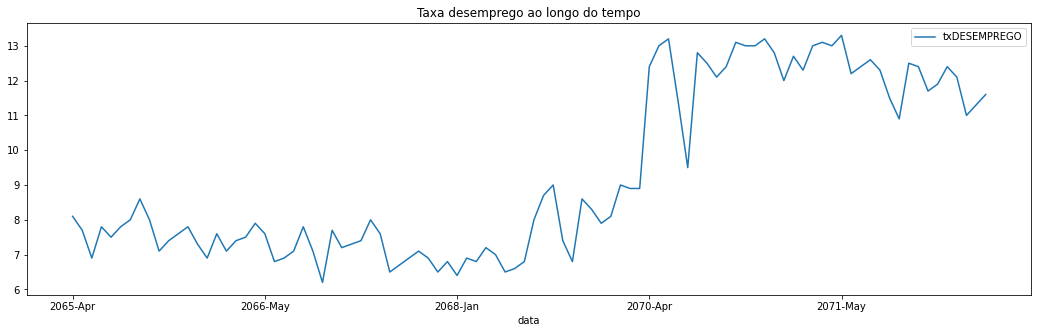

In [450]:
cen_graph.plot('data','txDESEMPREGO')
plt.title('Taxa desemprego ao longo do tempo')
plt.show()

**Com a pandemia de 2070 a taxa de desemprego subiu para impressionantes 13% em janeiro de 2071 (hoje), a taxa futura permanece alta.**

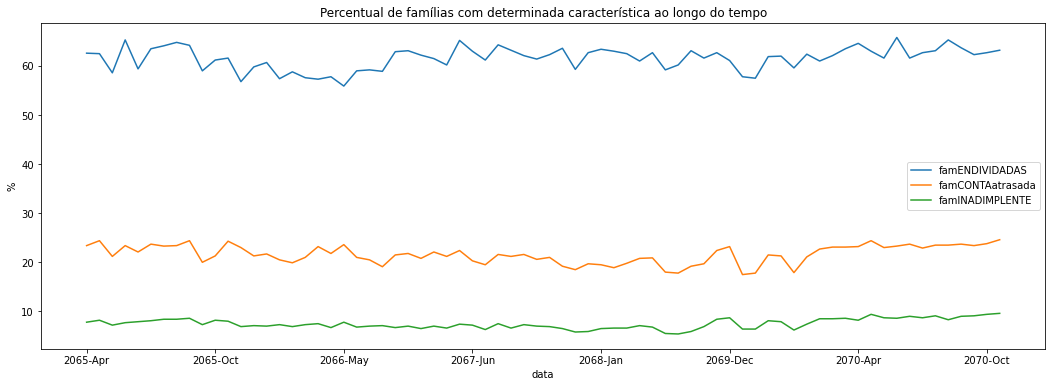

In [437]:
ax = cen_graph.plot('data','famENDIVIDADAS')
bx = cen_graph.plot('data','famCONTAatrasada', ax=ax)
cen_graph.plot('data','famINADIMPLENTE', ax=bx)
plt.title('Percentual de famílias com determinada característica ao longo do tempo')
plt.ylabel('%')
plt.show()

**Apesar da crise, o percentual de famílias endividadas, com contas atrasadas e inadimplentes parece não ter sofrido grandes alterações em relação a sua média histórica.**

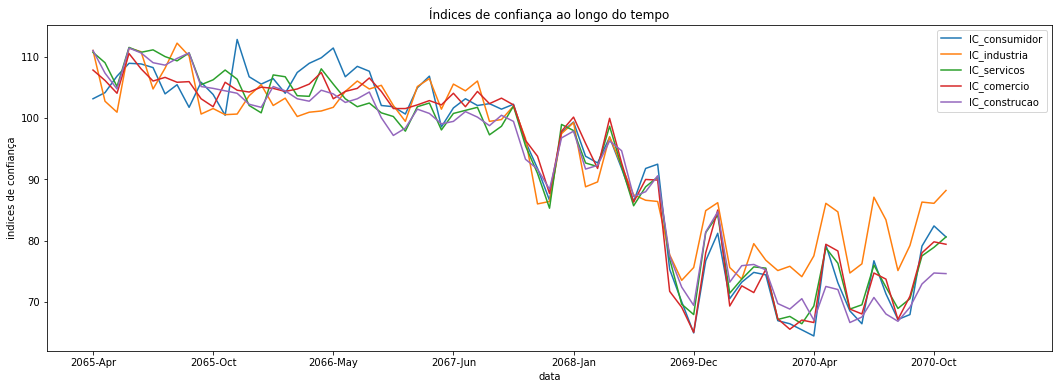

In [438]:
cx = cen_graph.plot('data','IC_consumidor')
dx = cen_graph.plot('data','IC_industria', ax=cx)
ex = cen_graph.plot('data','IC_servicos', ax=dx)
fx = cen_graph.plot('data','IC_comercio', ax=dx)
cen_graph.plot('data','IC_construcao', ax = fx)
plt.title('Índices de confiança ao longo do tempo')
plt.ylabel('indices de confiança')
plt.show()

**Os indices de confiança do mercado despencaram, o que pode ser um sinal de alerta para o Banco. Porém já parecem apresentar recuperação a partir de abril de 2070, contudo a volatilidade está bem alta, muito acima do padrão.**

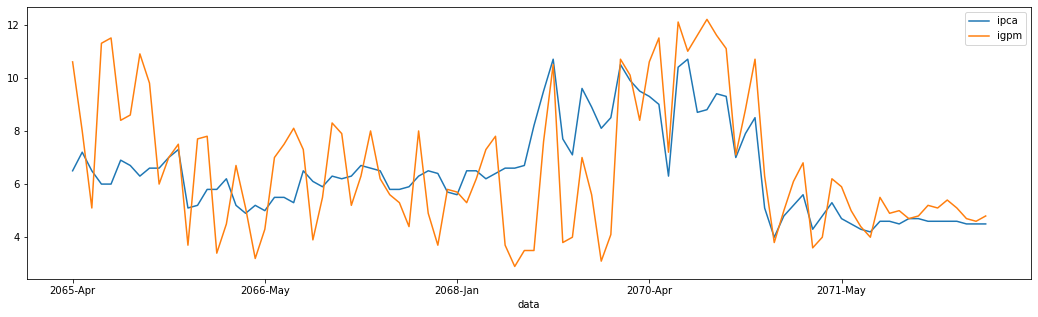

In [453]:
gx = cen_graph.plot('data','ipca')
cen_graph.plot('data','igpm', ax=gx)
plt.show()

**Durante o periodo da pandemia ambos os indices tiveram um aumento e o igpm teve um aumento significativo em sua volatilidade. No atual momento ambos parecem normalizados e as projeções para o futuro são boas.** 

# Revisitando alguns gráficos e comparando o cenário economico com os dados do C6

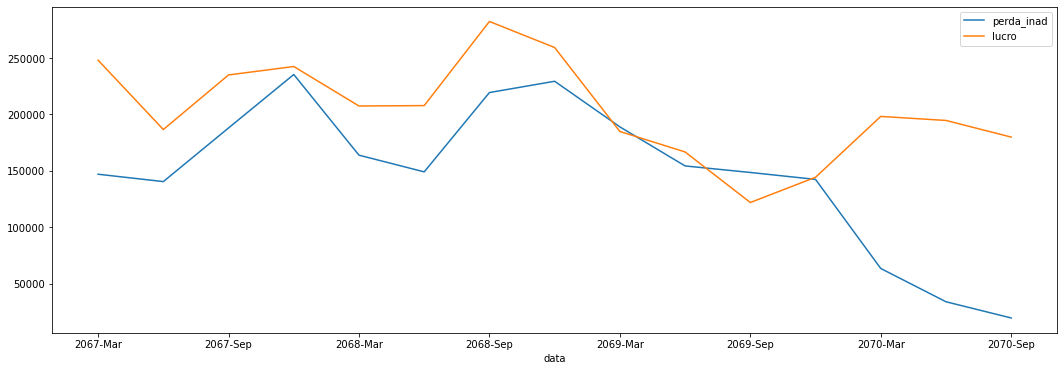

In [440]:
g1 = data_inad.plot(x='data',y='perda_inad')
data_lucro.plot(x='data',y='lucro', ax=g1)
plt.show()

**O banco parece ter tido quedas significantes em seu lucro no período que antecedeu a pandemia (ano de 2069) e surpreendemente melhorou seu desempenho durante o período da pandemia. Os gestores e o mais novo diretor Victor Esmeraldo estão de parabéns!**

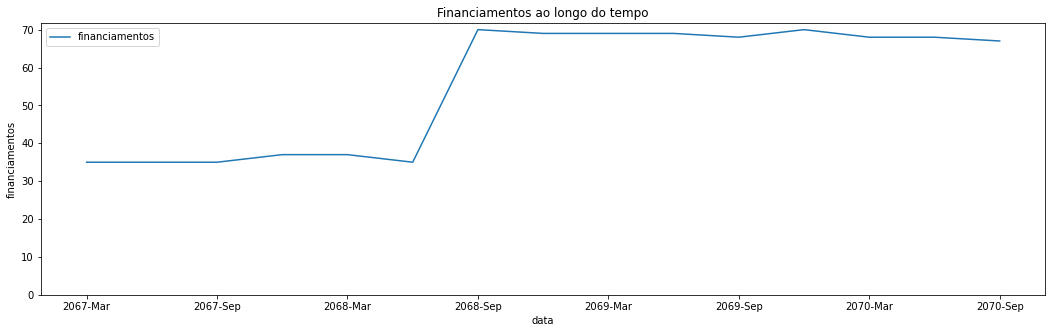

In [451]:
data_clientes.plot(x='data',y='financiamentos')
plt.title('Financiamentos ao longo do tempo')
plt.xlabel('data')
plt.ylabel('financiamentos')
plt.ylim(ymin=0)
plt.show()

**O número de negócios também não parece ter sido atingido pela crise.** 

# Conclusão

**Próximos passos para o C6:**
* Melhorar o algoritmo classificatório de risco
* Focar em clientes de baixo e médio risco, pelo menos até a crise passar.
* Ao voltar a investir em clientes de alto risco, melhorar as margens para que o risco valha a pena.
* Dar atenção especial em financiamentos de máquinas de energia Solar.
* Dar preferência para financiamentos com prazos mais curtos, principalmente os vencedores (0-6 meses e 13-24 meses).